In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
tf.test.is_built_with_cuda()

True

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras import backend as K
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

# Data Fetching

In [3]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16])
    out= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19])
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)


[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


# Min Max Scaler

In [4]:
from sklearn.decomposition import FastICA
import warnings
scaler_obj1=FastICA()
scaler_obj2=FastICA()
X1=scaler_obj1.fit_transform(A1)
Y1=scaler_obj2.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [5]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Model

In [6]:
inp=keras.Input(shape=(1,5))

l=keras.layers.Conv1D(16,1,padding="same",activation="tanh",kernel_initializer="glorot_uniform")(inp)
 
output = keras.layers.Conv1D(7,4,padding="same",activation='sigmoid')(l)

model1=keras.Model(inputs=inp,outputs=output)
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy',metrics=['accuracy','mse','mae',rmse])
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5)]            0         
                                                                 
 conv1d (Conv1D)             (None, 1, 16)             96        
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 7)              455       
                                                                 
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

history1 = model1.fit(x_train,y_train,batch_size=256,epochs=50, validation_data=(x_test, y_test),verbose = 2, shuffle= False)

Epoch 1/50
5070/5070 - 523s - loss: 0.6618 - accuracy: 0.0028 - mse: 0.2344 - mae: 0.4840 - rmse: 0.4840 - val_loss: 0.6220 - val_accuracy: 9.2470e-06 - val_mse: 0.2145 - val_mae: 0.4631 - val_rmse: 0.4631 - 523s/epoch - 103ms/step
Epoch 2/50
5070/5070 - 254s - loss: 0.5715 - accuracy: 1.8494e-05 - mse: 0.1896 - mae: 0.4350 - rmse: 0.4351 - val_loss: 0.5176 - val_accuracy: 9.2470e-06 - val_mse: 0.1633 - val_mae: 0.4039 - val_rmse: 0.4041 - 254s/epoch - 50ms/step
Epoch 3/50
5070/5070 - 248s - loss: 0.4597 - accuracy: 1.8494e-05 - mse: 0.1361 - mae: 0.3680 - rmse: 0.3683 - val_loss: 0.4013 - val_accuracy: 1.1559e-05 - val_mse: 0.1094 - val_mae: 0.3303 - val_rmse: 0.3308 - 248s/epoch - 49ms/step
Epoch 4/50
5070/5070 - 281s - loss: 0.3445 - accuracy: 1.7724e-05 - mse: 0.0854 - mae: 0.2908 - rmse: 0.2914 - val_loss: 0.2896 - val_accuracy: 1.1559e-05 - val_mse: 0.0635 - val_mae: 0.2512 - val_rmse: 0.2519 - 281s/epoch - 55ms/step
Epoch 5/50
5070/5070 - 233s - loss: 0.2405 - accuracy: 1.6953e-

Epoch 34/50
5070/5070 - 202s - loss: 9.9811e-07 - accuracy: 0.3550 - mse: 6.9622e-07 - mae: 1.4081e-04 - rmse: 2.4905e-04 - val_loss: 3.3004e-06 - val_accuracy: 0.3541 - val_mse: 2.2314e-07 - val_mae: 1.3996e-04 - val_rmse: 2.4779e-04 - 202s/epoch - 40ms/step
Epoch 35/50
5070/5070 - 204s - loss: 8.8319e-07 - accuracy: 0.3550 - mse: 6.9621e-07 - mae: 1.4078e-04 - rmse: 2.4902e-04 - val_loss: 3.2027e-06 - val_accuracy: 0.3541 - val_mse: 2.2314e-07 - val_mae: 1.3994e-04 - val_rmse: 2.4777e-04 - 204s/epoch - 40ms/step
Epoch 36/50
5070/5070 - 219s - loss: 7.8108e-07 - accuracy: 0.3550 - mse: 6.9621e-07 - mae: 1.4076e-04 - rmse: 2.4900e-04 - val_loss: 3.1162e-06 - val_accuracy: 0.3541 - val_mse: 2.2313e-07 - val_mae: 1.3992e-04 - val_rmse: 2.4775e-04 - 219s/epoch - 43ms/step
Epoch 37/50
5070/5070 - 202s - loss: 6.8973e-07 - accuracy: 0.3550 - mse: 6.9621e-07 - mae: 1.4075e-04 - rmse: 2.4899e-04 - val_loss: 3.0390e-06 - val_accuracy: 0.3541 - val_mse: 2.2313e-07 - val_mae: 1.3990e-04 - val_rm

In [8]:
model1.evaluate(x_test,y_test)

13518/13518 [==============================] - 399s 29ms/step - loss: 2.4856e-06 - accuracy: 0.3541 - mse: 2.2313e-07 - mae: 1.3978e-04 - rmse: 2.4761e-04


[2.485594222889631e-06,
 0.35413607954978943,
 2.231279268016806e-07,
 0.00013978300557937473,
 0.0002476123336236924]

# Saving Model as File

In [9]:
model1.evaluate(x_train,y_train)

40554/40554 [==============================] - 1103s 27ms/step - loss: -2.7078e-09 - accuracy: 0.3550 - mse: 6.9621e-07 - mae: 1.4062e-04 - rmse: 2.4886e-04


[-2.7077968756117343e-09,
 0.35497426986694336,
 6.9621353304683e-07,
 0.0001406207011314109,
 0.0002488576283212751]

In [10]:
df1=pd.DataFrame(history1.history['loss'],columns=["Loss"])
df1=df1.join(pd.DataFrame(history1.history["val_loss"],columns=["Val Loss"]))
df1=df1.join(pd.DataFrame(history1.history["accuracy"],columns=['Accuracy']))
df1=df1.join(pd.DataFrame(history1.history["val_accuracy"],columns=['Val Accuracy']))
df1=df1.join(pd.DataFrame(history1.history["mse"],columns=['MSE']))
df1=df1.join(pd.DataFrame(history1.history["val_mse"],columns=['Val MSE']))
df1=df1.join(pd.DataFrame(history1.history["mae"],columns=['MAE']))
df1=df1.join(pd.DataFrame(history1.history["val_mae"],columns=['Val MAE']))
df1=df1.join(pd.DataFrame(history1.history["rmse"],columns=['RMSE']))
df1=df1.join(pd.DataFrame(history1.history["val_mse"],columns=['Val RMSE']))
df1

,Loss,Val Loss,Accuracy,Val Accuracy,MSE,Val MSE,MAE,Val MAE,RMSE,Val RMSE
0,6.618441e-01,0.622004,0.002763,0.000009,2.343637e-01,2.144970e-01,0.483971,0.463077,0.483990,2.144970e-01
1,5.715299e-01,0.517572,0.000018,0.000009,1.896174e-01,1.633012e-01,0.434984,0.403882,0.435116,1.633012e-01
2,4.597020e-01,0.401270,0.000018,0.000012,1.361095e-01,1.094090e-01,0.367983,0.330312,0.368320,1.094090e-01
3,3.444729e-01,0.289610,0.000018,0.000012,8.542769e-02,6.345860e-02,0.290807,0.251218,0.291388,6.345860e-02
4,2.404990e-01,0.194870,0.000017,0.000012,4.627156e-02,3.157796e-02,0.213268,0.176885,0.214034,3.157796e-02
5,1.568990e-01,0.122808,0.000017,0.000012,2.154500e-02,1.351455e-02,0.144889,0.115465,0.145702,1.351455e-02
6,9.619147e-02,0.072987,0.000017,0.000012,8.684145e-03,5.038568e-03,0.091544,0.070338,0.092265,5.038568e-03
7,5.582185e-02,0.041221,0.000017,0.000012,3.076361e-03,1.667072e-03,0.054222,0.040363,0.054775,1.667072e-03
8,3.089256e-02,0.022284,0.000017,0.000009,9.759546e-04,4.991913e-04,0.030395,0.022030,0.030775,4.991913e-04
9,1.641461e-02,0.011605,0.000017,0.000009,2.825651e-04,1.378612e-04,0.016274,0.011535,0.016514,1.378612e-04


In [11]:
df1.to_excel("GRU_tanh_mse.xlsx")

In [12]:
model_json = model1.to_json()
with open("cnn_relu.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("cnn_relu.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

from keras.models import model_from_json
json_file = open('cnn_relu.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("cnn_relu.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='mse',metrics=['accuracy','mse','mae',rmse])

Loaded model from disk


In [14]:
loaded_model.evaluate(x_train, y_train, verbose=0)

[6.9621353304683e-07,
 0.35497426986694336,
 6.9621353304683e-07,
 0.0001406207011314109,
 0.0002488576283212751]

In [15]:
loaded_model.evaluate(x_test, y_test, verbose=0)

[2.231279268016806e-07,
 0.35413607954978943,
 2.231279268016806e-07,
 0.00013978300557937473,
 0.0002476123336236924]

# Error Analysis

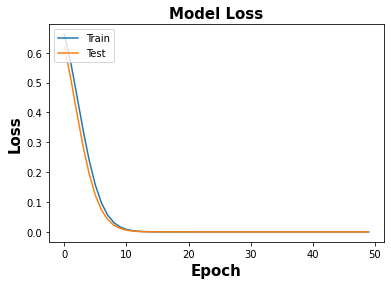

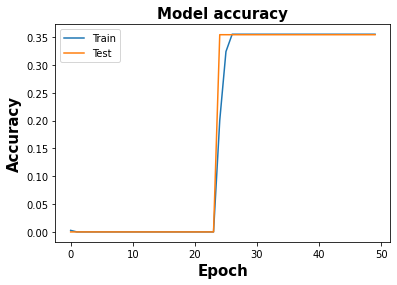

In [16]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss',fontweight ='bold',fontsize = 15)
plt.ylabel('Loss',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy',fontweight ='bold',fontsize = 15)
plt.ylabel('Accuracy',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=loaded_model.predict(x_test)
y_test_pred

array([[[9.8994178e-07, 8.5192926e-07, 8.7033595e-07, ...,
         9.0581261e-07, 1.0630009e-06, 8.3384282e-07]],

       [[9.9125577e-07, 8.5294886e-07, 8.7136573e-07, ...,
         9.0697949e-07, 1.0644424e-06, 8.3505648e-07]],

       [[9.9087958e-07, 8.5282028e-07, 8.7121447e-07, ...,
         9.0691640e-07, 1.0641816e-06, 8.3488123e-07]],

       ...,

       [[9.9180431e-07, 8.5369584e-07, 8.7210390e-07, ...,
         9.0792713e-07, 1.0652903e-06, 8.3577669e-07]],

       [[9.9100725e-07, 8.5274138e-07, 8.7106997e-07, ...,
         9.0662928e-07, 1.0641126e-06, 8.3473083e-07]],

       [[9.9225178e-07, 8.5388803e-07, 8.7251158e-07, ...,
         9.0815149e-07, 1.0656632e-06, 8.3599195e-07]]], dtype=float32)

In [18]:
y_test

array([[[ 1.25360448e-05, -2.13416334e-05, -1.73507257e-06, ...,
         -1.76974652e-04,  4.15045421e-05, -5.05942262e-04]],

       [[ 2.54985365e-07,  1.31483315e-05, -2.52162762e-06, ...,
         -3.67749602e-05,  2.63031599e-04, -1.95993814e-04]],

       [[-1.69268897e-05,  4.79727685e-05,  3.93530788e-05, ...,
          7.04869713e-04,  9.77032532e-05,  3.07603021e-04]],

       ...,

       [[-1.33763804e-05,  4.80857031e-05,  8.61993791e-06, ...,
          2.88330758e-04,  1.39952700e-05,  1.13278514e-03]],

       [[ 1.09496671e-05,  4.41026262e-06, -4.21493817e-06, ...,
         -2.08909401e-04,  2.43726005e-04, -2.78745144e-04]],

       [[ 5.73979254e-06, -1.61403154e-05, -1.53937046e-05, ...,
         -2.02710279e-04,  2.46700959e-05, -4.59921932e-04]]])

In [19]:
y_test=y_test[:,0]
y_test_pred=y_test_pred[:,0]

In [20]:
from numpy import savetxt
savetxt('cnn_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

In [21]:
from numpy import savetxt
savetxt('cnn_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed